# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Chaves, Noelia
- Frau, Johanna

### Mentora:

- Dal Lago, Virginia

### Práctico: Introducción al aprendizaje automático

## Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

## Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.




## Objetivos generales

  * Realizar de manera completa el proceso de desarrollo de un modelo de aprendizaje automático para determinar cuándo llega un envío.
  * Desarrollar el conocimiento práctico sobre dicho proceso, desde la definición de los datasets, la elección y análisis del modelo y las métricas propias para la problemática.
  * Desarrollar habilidades de comunicación de la información obtenida a partir de los datos de manera clara y sencilla.

## Objetivos específicos

* Probar diferentes modelos de aprendizaje automático ver cual se comporta mejor con nuestro dataset.
* Hacer una partición de los datos que tenga sentido en nuestra problemática.
* Seguir analizando cuáles features resultan más importantes en la predicción a realizar.

## Desarrollo del trabajo

In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn


from IPython.display import HTML
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from datetime import timedelta

from sklearn import tree
import graphviz
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

### Lectura y análisis inicial de los datos

In [189]:
url = "https://raw.githubusercontent.com/cnoeliachaves/csv/master/dataset_sample_corrected.csv"

dataset = pandas.read_csv(url, dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])
dataset.shape

(500000, 12)

In [4]:
dataset.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days'],
      dtype='object')

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        500000 non-null object
sender_zipcode      500000 non-null int64
receiver_state      500000 non-null object
receiver_zipcode    500000 non-null int64
shipment_type       500000 non-null object
quantity            500000 non-null int64
service             500000 non-null int64
status              500000 non-null object
date_created        500000 non-null datetime64[ns]
date_sent           499971 non-null datetime64[ns]
date_visit          499398 non-null datetime64[ns]
shipment_days       499398 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 45.8+ MB


In [132]:
np.random.seed(0) #con propositos de reproducibilidad
dataset.sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
194257,SP,3734,RS,96540,standard,1,4,done,2019-02-17,2019-02-22 03:49:21,2019-03-07 15:09:00,6.0
396319,SP,6422,SP,9580,express,1,5,done,2019-03-04,2019-03-07 20:24:02,2019-03-07 10:02:09,0.0
138738,SP,14940,CE,62650,standard,1,1,done,2019-02-08,2019-02-13 13:51:00,2019-03-11 14:16:00,15.0
66570,SP,1004,MG,32340,express,1,4,done,2019-03-16,2019-03-19 00:52:07,2019-03-25 19:00:00,4.0
149424,SP,13254,BA,44700,express,1,0,done,2019-03-02,2019-03-04 15:41:00,2019-03-12 15:19:00,3.0
128165,SP,9850,SP,12301,express,2,0,done,2019-03-17,2019-03-19 13:39:00,2019-03-20 18:59:00,1.0
264495,SP,3627,BA,44690,standard,1,1,done,2019-03-04,2019-03-06 12:13:00,2019-03-22 14:17:00,11.0
30371,SP,13456,SP,5268,express,2,0,done,2019-03-12,2019-03-13 15:07:00,2019-03-14 16:26:00,1.0
456998,SP,3004,SC,89300,standard,1,3,done,2019-02-15,2019-02-17 04:52:00,2019-03-07 17:56:00,10.0
32001,SP,19013,SP,14815,standard,2,1,done,2019-03-21,2019-03-22 14:32:00,2019-03-26 13:39:00,2.0


### Limpieza de datos

En esta sección retomaremos algunos puntos del práctico anterior con el objetivo de limpiar nuestro dataset.

**Shipment day anómalos**

En primer lugar, eliminaremos los valores de shipment days negativos.

In [133]:
def clean_shipment_days(dataset):
    """Le saco los valores negativos"""
    shipments_days = dataset['shipment_days']
    mask = (shipments_days >= 0)
    return dataset[mask] 

In [134]:
dataset_clean = clean_shipment_days(dataset)

**Fechas anómalas**

En el análisis realizado en el práctico anterior de las 3 variables con información de fechas y horas encontramos que la variable date_created cuenta con valores que caen fuera del intervalo temporal considerado y que todos ellos se encuentran ubicados en el mes de Junio de 2019. Luego de haber realizado una inspección de esta información anómala llegamos a la conclusión que los mismos podrían deberse a un error en el proceso de carga y que en realidad son datos de Enero de 2019. 

Siguiendo esta idea decidimos en este momento subsanar este posible error de carga haciendo que la información de la variable date_created correspondiente al mes de Junio de 2019 sea ahora del mes de Enero de 2019.

In [135]:
date_created_junio = dataset_clean[dataset_clean['date_created'].map(lambda x: x.month) == 6]
date_created_junio

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
14265,SP,2350,RJ,20261,express,1,7,done,2019-06-27,2019-02-06 05:57:00,2019-03-01 11:31:00,17.0
18211,SP,7756,SP,13214,express,1,7,done,2019-06-27,2019-02-06 05:00:00,2019-03-01 09:08:00,17.0
27700,SP,5034,GO,74565,standard,1,7,done,2019-06-26,2019-02-06 10:56:00,2019-03-01 11:54:00,17.0
28540,SP,9060,MA,65050,standard,1,4,done,2019-06-20,2019-02-06 10:00:00,2019-03-01 12:02:00,17.0
33158,SP,16204,MG,31910,standard,2,7,done,2019-06-27,2019-02-06 04:03:00,2019-03-01 16:43:00,17.0
38127,SP,2460,SP,13335,express,1,7,done,2019-06-26,2019-03-06 01:18:00,2019-03-07 14:03:00,0.0
42758,SP,1042,SP,11070,express,1,4,done,2019-06-25,2019-02-06 05:01:00,2019-03-01 16:09:00,17.0
43607,SP,6422,RS,91750,standard,1,7,done,2019-06-19,2019-02-06 04:41:00,2019-03-01 14:30:00,17.0
45731,SP,14405,ES,29164,standard,1,7,done,2019-06-22,2019-03-06 03:02:00,2019-03-07 04:27:00,0.0
58502,SP,12950,ES,29800,standard,1,7,done,2019-06-25,2019-02-06 04:42:00,2019-03-01 07:29:00,17.0


In [136]:
date_created_junio = dataset_clean['date_created'].map(lambda x: x+timedelta(days=-151) if x.month==6 else x) 
dataset_clean['date_created'] = date_created_junio

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [137]:
dataset_clean['date_created'].dt.month.unique()

array([ 3,  2,  1,  4, 12, 10, 11], dtype=int64)

In [11]:
dataset_clean.describe(include='datetime64')

,date_created,date_sent,date_visit
count,499350,499350,499350
unique,124,81276,55668
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20424,113,621
first,2018-10-21 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-04-29 00:00:00,2019-03-29 01:46:20,2019-04-02 15:35:00


En el describe de arriba, podemos ver que la última fecha de creación es posterior a la última fecha de data_sent como date_visit, pero consideramos que dichos datos son correctos, ya que no contamos con el completo dataset.

Veamos cuantos valores nulos tenemos

In [12]:
null_values_count = dataset_clean.isnull().sum()
# look at the # of missing points in the first ten columns
null_values_count[null_values_count > 0]

Series([], dtype: int64)

Podemos ver que no tenemos valores nulos en el dataset.

### La importancia de predecir el valor de la variable shipment_days

Uno de los objetivos principales del análisis propuesto en esta mentoría es predecir (dar un número aproximado de días hábiles) de cuanto va a tardar en llegar un envío desde que el cliente realiza la compra a través de la plataforma de Mercado Libre hasta que el paquete llega a su casa. Dicha predicción es importante porque es la que recibe el cliente y es la que determinará en una buena proporción la experiencia del usuario dentro la plataforma.

Esto nos lleva a pensar que dicha predicción se parecerá a los valores de la variable shipment_days con, quizás, 1 o 2 días más de diferencia. Pues este último feature cuenta el intervalo de días entre date_sent y date_visit y nosotros necesitamos dar la aproximación a partir del momento de la compra. Por lo tanto este sería el target de un algoritmo de aprendizaje automático. Si bien este feature originalmente es información de tipo numérica en el práctico anterior utilizamos enconding para convertirla en una variable categórica. Así, esto nos da la posibilidad de trabajar con diferentes modelos de aprendizaje automático utilizando el mismo feature como target pero en sus diferentes versiones.

Frente a este problema consideramos que el estado de Brasil que recibe el envío (receiver_state) es un feature importante a tener en cuenta (mientras más lejos esté de San Pablo probablemente demore más) y probablemente también el código postal de dicho estado (receiver_zipcode). Por otro lado, el tipo de correo (service) también puede ser una variable importante a tener en cuenta porque la calidad de servicio impactará directamente en los días que tarda en llegar el pedido.



In [13]:
dataset_clean.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
217231,SP,3191,MT,78525,standard,2,1,done,2019-03-12,2019-03-12 15:21:00,2019-03-20 13:21:00,6.0
117468,SP,1022,SC,88062,standard,1,1,done,2019-02-20,2019-02-20 16:14:00,2019-03-15 10:27:00,14.0
94430,SP,3273,BA,45206,standard,2,1,done,2019-02-25,2019-02-28 04:32:36,2019-03-19 16:03:00,10.0
269245,SP,1025,SP,5019,express,1,8,done,2019-03-16,2019-03-19 21:29:08,2019-03-20 14:19:13,1.0
84016,SP,18070,MG,31030,express,2,4,done,2019-03-21,2019-03-21 22:57:20,2019-03-26 20:08:00,3.0


In [0]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492881 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        492881 non-null object
sender_zipcode      492881 non-null int64
receiver_state      492881 non-null object
receiver_zipcode    492881 non-null int64
shipment_type       492881 non-null object
quantity            492881 non-null int64
service             492881 non-null int64
status              492881 non-null object
date_created        492881 non-null datetime64[ns]
date_sent           492881 non-null datetime64[ns]
date_visit          492881 non-null datetime64[ns]
shipment_days       492881 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 48.9+ MB


Luego de haber limpiado nuestro dataset observamos que contamos con 492881 filas con información, es decir la limpieza solo afectó al 1,42% de los datos originales.



### Label encoder y OneHotEncoder de la variable receiver_state

En esta sección vamos a recuperar los encondings realizados en el práctico anterior a la variable receiver_state con la idea de entrenar nuestro modelo también con este feature.

**Label Encoder**

In [138]:
receiver_state_le = 'receiver_state'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(dataset_clean[receiver_state_le])

LabelEncoder()

In [139]:
# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))

{'AC': 0,
 'AL': 1,
 'AM': 2,
 'AP': 3,
 'BA': 4,
 'CE': 5,
 'DF': 6,
 'ES': 7,
 'GO': 8,
 'MA': 9,
 'MG': 10,
 'MS': 11,
 'MT': 12,
 'PA': 13,
 'PB': 14,
 'PE': 15,
 'PI': 16,
 'PR': 17,
 'RJ': 18,
 'RN': 19,
 'RO': 20,
 'RR': 21,
 'RS': 22,
 'SC': 23,
 'SE': 24,
 'SP': 25,
 'TO': 26}

In [140]:
dataset_clean['receiver_state_le'] = receiver_state_le
dataset_clean.sample(5)

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,receiver_state_le
63285,SP,13575,MG,36815,standard,1,1,done,2019-03-04,2019-03-07 09:14:00,2019-03-15 13:56:00,6.0,receiver_state
300314,SP,3004,PR,84266,standard,1,6,done,2019-02-25,2019-02-27 10:06:26,2019-03-07 15:29:58,3.0,receiver_state
433899,SP,4007,MG,38745,standard,1,1,done,2019-02-27,2019-02-27 17:47:00,2019-03-11 13:56:00,5.0,receiver_state
122501,SP,9951,SP,18690,express,1,0,done,2019-03-02,2019-03-05 13:49:00,2019-03-11 12:23:00,2.0,receiver_state
202392,SP,17400,RN,59900,standard,1,1,done,2019-03-06,2019-03-06 15:49:00,2019-03-14 14:08:00,5.0,receiver_state


**OneHotEncoder**

In [141]:
dataset_ohe = pandas.get_dummies(dataset_clean, columns = ["receiver_state"])
dataset_clean = dataset_ohe
dataset_clean.head()

,sender_state,sender_zipcode,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,...,receiver_state_PR,receiver_state_RJ,receiver_state_RN,receiver_state_RO,receiver_state_RR,receiver_state_RS,receiver_state_SC,receiver_state_SE,receiver_state_SP,receiver_state_TO
0,SP,1039,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,...,0,0,0,0,0,0,0,0,1,0
1,SP,3004,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,...,0,0,0,0,0,0,0,0,0,0
2,SP,3262,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,...,0,1,0,0,0,0,0,0,0,0
3,SP,12237,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,...,0,0,0,0,0,0,0,0,1,0
4,SP,9350,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# creamos una nueva columna donde date_created solo considera las fechas
dataset_clean['date_created_only_date'] = dataset_clean['date_created'].dt.date

In [143]:
# creamos una nueva columna donde date_visit solo considera las fechas
dataset_clean['date_visit_only_date'] = dataset_clean['date_visit'].dt.date 

In [144]:
dataset_clean.sort_values(by=['date_visit_only_date']) 

,sender_state,sender_zipcode,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,...,receiver_state_RN,receiver_state_RO,receiver_state_RR,receiver_state_RS,receiver_state_SC,receiver_state_SE,receiver_state_SP,receiver_state_TO,date_created_only_date,date_visit_only_date
458914,SP,12570,68870,standard,2,1,done,2019-02-03,2019-02-04 15:02:00,2019-02-25 16:48:00,...,0,0,0,0,0,0,0,0,2019-02-03,2019-02-25
82051,SP,14409,44920,standard,2,1,done,2019-02-06,2019-02-06 16:34:00,2019-02-25 14:59:00,...,0,0,0,0,0,0,0,0,2019-02-06,2019-02-25
179344,SP,9182,48970,standard,1,1,done,2019-02-08,2019-02-08 12:08:00,2019-02-25 15:22:00,...,0,0,0,0,0,0,0,0,2019-02-08,2019-02-25
187209,SP,8725,28943,standard,1,1,done,2019-02-01,2019-02-01 12:37:00,2019-02-25 12:53:00,...,0,0,0,0,0,0,0,0,2019-02-01,2019-02-25
2556,SP,13171,65730,standard,1,1,done,2019-01-25,2019-01-28 16:33:00,2019-02-25 16:07:00,...,0,0,0,0,0,0,0,0,2019-01-25,2019-02-25
491848,SP,5787,27570,standard,1,1,done,2019-01-30,2019-01-30 16:16:00,2019-02-25 18:34:00,...,0,0,0,0,0,0,0,0,2019-01-30,2019-02-25
104449,SP,4444,96065,standard,1,1,done,2019-01-25,2019-01-28 11:33:00,2019-02-25 11:17:00,...,0,0,0,1,0,0,0,0,2019-01-25,2019-02-25
238665,SP,6422,20745,standard,1,2,done,2019-02-08,2019-02-11 20:19:40,2019-02-25 10:41:00,...,0,0,0,0,0,0,0,0,2019-02-08,2019-02-25
373677,SP,9726,58417,standard,2,1,done,2019-01-31,2019-02-01 12:41:00,2019-02-25 15:06:00,...,0,0,0,0,0,0,0,0,2019-01-31,2019-02-25
314661,SP,3417,49180,standard,1,1,done,2019-01-31,2019-02-01 15:44:00,2019-02-25 13:33:00,...,0,0,0,0,0,1,0,0,2019-01-31,2019-02-25


Según podemos observar en los cálculos de arriba la variable date_visit  abarca desde el 25-02-2019 al 02-04-2019.

Veamos ahora como se distribuyen estos datos dentro de este intervalo temporal.

In [23]:
dataset_clean['date_visit'].groupby([dataset_clean['date_visit'].dt.month.rename('month'), dataset_clean['date_visit'].dt.day.rename('day')]).agg({'count'})

count
month day       
2     25    2021
      26    1617
      27    2663
      28   21659
3     1    20909
      7    34280
      8    38442
      11   35573
      12   36365
      13   25702
      14   25169
      15   24035
      18   31013
      19   24467
      20   25683
      21   23491
      22   22772
      25   28824
      26   23529
      27   24538
      28   22123
      29    3119
4     1     1309
      2       47

In [24]:
dataset_clean['date_visit'].groupby([dataset_clean['date_visit'].dt.month.rename('month')]).agg({'count'})

,count
month,
2,27960
3,470034
4,1356


Considerando que nuestro dataset cuenta en este momento con 492881 entradas, el 70% del mismo representa aproximadamente 345000 entradas. Así, de acuerdo a la distribución mostrada arriba si entrenamos nuestro modelo con datos de la variable date_visit hasta el 20 de marzo podriamos llegar a cubrir este porcentaje.

A continuación se realizan los cálculos que permitirán hacer la partición de los datos de acuerdo al criterio antes mencionado.

In [0]:
#mask1 = (dataset_clean['date_visit'].dt.month==2) | ((dataset_clean['date_visit'].dt.day<=20) & (dataset_clean['date_visit'].dt.month==3))
#mask2 = (dataset_clean['date_created'].dt.month==4) | ((dataset_clean['date_created'].dt.day>20) & (dataset_clean['date_created'].dt.month==3))

In [145]:
mask1 = dataset_clean['date_visit']<=pandas.to_datetime('2019-03-20')
mask2 = dataset_clean['date_created']<=pandas.to_datetime('2019-03-20')

Eliminamos los valores que cumplen con las dos condiciones simultáneamente.

In [146]:
dataset_clean.drop(dataset_clean[mask1&mask2].index, inplace = True)

In [147]:
df_train = dataset_clean.loc[mask1]
df_train

,sender_state,sender_zipcode,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,...,receiver_state_RN,receiver_state_RO,receiver_state_RR,receiver_state_RS,receiver_state_SC,receiver_state_SE,receiver_state_SP,receiver_state_TO,date_created_only_date,date_visit_only_date
30428,SP,19160,13146,express,1,4,failed,2019-04-23,2019-03-04 16:36:00,2019-03-07 16:36:00,...,0,0,0,0,0,0,1,0,2019-04-23,2019-03-07
39563,SP,9951,55293,standard,1,10,failed,2019-04-14,2019-03-04 17:52:00,2019-03-07 17:52:00,...,0,0,0,0,0,0,0,0,2019-04-14,2019-03-07
75906,SP,13920,6725,express,1,4,failed,2019-04-11,2019-03-04 13:00:00,2019-03-07 13:00:00,...,0,0,0,0,0,0,1,0,2019-04-11,2019-03-07
90091,SP,9550,13212,express,1,4,failed,2019-04-24,2019-02-04 05:44:00,2019-02-27 15:00:00,...,0,0,0,0,0,0,1,0,2019-04-24,2019-02-27
90329,SP,3949,79750,standard,1,4,failed,2019-04-14,2019-03-04 17:33:00,2019-03-07 17:33:00,...,0,0,0,0,0,0,0,0,2019-04-14,2019-03-07
93500,SP,7411,72308,standard,1,4,failed,2019-04-27,2019-03-04 16:31:00,2019-03-07 20:00:00,...,0,0,0,0,0,0,0,0,2019-04-27,2019-03-07
97833,SP,13274,18071,express,1,4,failed,2019-04-24,2019-03-04 21:29:00,2019-03-07 21:29:00,...,0,0,0,0,0,0,1,0,2019-04-24,2019-03-07
167964,SP,11060,94070,standard,1,4,failed,2019-04-25,2019-03-04 16:00:00,2019-03-07 16:00:00,...,0,0,0,1,0,0,0,0,2019-04-25,2019-03-07
176607,SP,4904,11680,standard,1,4,failed,2019-04-26,2019-03-04 16:01:00,2019-03-07 16:01:00,...,0,0,0,0,0,0,1,0,2019-04-26,2019-03-07
180164,SP,4691,25725,standard,1,4,failed,2019-04-23,2019-03-04 15:00:00,2019-03-07 15:00:00,...,0,0,0,0,0,0,0,0,2019-04-23,2019-03-07


In [148]:
df_test = dataset_clean.loc[mask2]

Nos quedan definidos los data set, tanto para entrenamiento como para validación. Entonces podemos definir los X_train, y_train , X_test, e y_test.

En X_train vamos a seleccionar los features que previamente habiamos elegimos como los mas representativos.

In [149]:
X_train = df_train[['receiver_zipcode','service']]

In [150]:
y_train = df_train[['shipment_days']]

In [151]:
X_test = df_test[['receiver_zipcode','service']]

In [152]:
y_test = df_test[['shipment_days']]

Corroboremos que todos nos quedaron del mismo tamaño:

In [168]:
X_train.shape

(32, 2)

In [169]:
X_test.shape

(142909, 2)

In [170]:
y_train.shape

(32, 2)

In [171]:
y_test.shape

(142909, 2)

### DecisionTree

Como nuestro y (shipment_days) es categórico consideramos mejor una clasificación.
Como primera elección consideramos decisiontree para ver como se comporta con la clasificación:

In [153]:
features_names = ["receiver_code","service"]

In [154]:
target_names = ["1","2","3","4","5","6"]

Para usar el clasificador desicionTree necesita que el target sea un valor entero, por ende convertimos shipment_day en entero:
(aca uso lo del practico 1)

In [155]:
shipment_days = y_train['shipment_days'].astype(int)
shipment_days_byclass = [None] * len(shipment_days)
for line,row in enumerate(shipment_days):
    if 0<= row<=3:
        shipment_days_byclass[line] = 1
    elif 3<row<=6:
        shipment_days_byclass[line] = 2     
    elif 6<row<=9:
        shipment_days_byclass[line] = 3
    elif 9<row<=12:
        shipment_days_byclass[line] = 4
    elif 12<row<=15:
        shipment_days_byclass[line] = 5        
    elif 15<row<=18:
        shipment_days_byclass[line] = 6
    else:
        shipment_days_byclass[line] = 7

In [156]:
y_train['shipment_days_byclass'] = shipment_days_byclass

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [157]:
y_train['shipment_days_byclass'].head()

30428    1
39563    1
75906    1
90091    6
90329    1
Name: shipment_days_byclass, dtype: int64

Hay que hacer lo mismo para los valores de validación:

In [114]:
y_test['shipment_days'].head().astype(int)

5     2
9     2
13    3
16    7
25    3
Name: shipment_days, dtype: int32

In [158]:
shipment_days_test = y_test['shipment_days'].astype(int)
shipment_days_byclass_test = [None] * len(shipment_days_test)
for line,row in enumerate(shipment_days_test):
    if 0<= row<=3:
        shipment_days_byclass_test[line] = 1
    elif 3<row<=6:
        shipment_days_byclass_test[line] = 2     
    elif 6<row<=9:
        shipment_days_byclass_test[line] = 3
    elif 9<row<=12:
        shipment_days_byclass_test[line] = 4
    elif 12<row<=15:
        shipment_days_byclass_test[line] = 5        
    elif 15<row<=18:
        shipment_days_byclass_test[line] = 6
    else:
        shipment_days_byclass_test[line] = 7

In [107]:
#y_test

,shipment_days,shipment_days_byclass
5,2.0,1.0
9,2.0,1.0
13,3.0,1.0
16,7.0,3.0
25,3.0,1.0
34,7.0,3.0
38,5.0,2.0
40,4.0,2.0
41,2.0,1.0
42,18.0,6.0


In [159]:
y_test['shipment_days_byclass'] = shipment_days_byclass_test

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [118]:
#y_test['shipment_days_byclass']

5         1
9         1
13        1
16        3
25        1
34        3
38        2
40        2
41        1
42        6
43        3
45        2
46        6
47        5
48        2
52        3
60        1
65        2
66        3
70        7
88        4
89        5
95        4
100       2
103       3
111       6
115       4
116       2
118       1
124       2
         ..
499865    1
499867    1
499870    1
499882    2
499883    1
499885    2
499891    3
499899    6
499901    3
499902    3
499904    5
499910    1
499912    3
499918    7
499926    4
499941    7
499949    3
499950    4
499954    2
499964    1
499965    1
499969    6
499972    2
499973    1
499977    1
499978    4
499979    6
499993    1
499996    1
499998    4
Name: shipment_days_byclass, Length: 142909, dtype: int64

In [119]:
X_train.head()

,receiver_zipcode,service
30428,13146,4
39563,55293,10
75906,6725,4
90091,13212,4
90329,79750,4


In [160]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train["shipment_days_byclass"])

In [161]:
predictions = clf.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train["shipment_days_byclass"] == predictions))/float(y_train["shipment_days_byclass"].size)*100))

Accuracy: 100 


In [162]:
predictions = clf.predict(X_test)
print ('Accuracy: %d ' % ((np.sum(y_test["shipment_days_byclass"] == predictions))/float(y_test["shipment_days_byclass"].size)*100))

Accuracy: 28 


In [163]:
print("Reporte de clasificación (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test["shipment_days_byclass"], clf.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

Reporte de clasificación (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           1       0.29      0.93      0.44     42713
           2       0.00      0.00      0.00     34086
           3       0.00      0.00      0.00     21656
           4       0.00      0.00      0.00     17928
           5       0.00      0.00      0.00     12407
           6       0.03      0.03      0.03      6902
           7       0.00      0.00      0.00      7217

   micro avg       0.28      0.28      0.28    142909
   macro avg       0.05      0.14      0.07    142909
weighted avg       0.09      0.28      0.13    142909




C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [164]:
print(confusion_matrix(y_true, y_pred)) 

[[39842     0     0     0     0  2871     0]
 [32654     0     0     0     0  1432     0]
 [20932     0     0     0     0   724     0]
 [17410     0     0     0     0   518     0]
 [12139     0     0     0     0   268     0]
 [ 6727     0     0     0     0   175     0]
 [ 7084     0     0     0     0   133     0]]


Para las 2 primeras clases anda bien, pero para las demas no tan bien, habria que probar otro modelo.
Probemos con SGDClassifier:

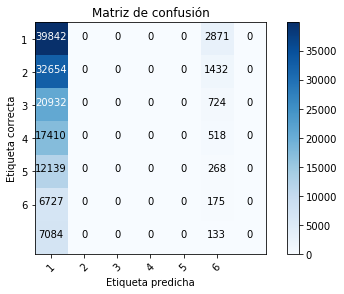

In [165]:
from ml.visualization import plot_confusion_matrix
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=target_names, title="Matriz de confusión")

In [166]:
np.random.seed(0)

In [181]:
y_train

,shipment_days,shipment_days_byclass
30428,0.0,1
39563,0.0,1
75906,0.0,1
90091,17.0,6
90329,0.0,1
93500,0.0,1
97833,0.0,1
167964,0.0,1
176607,0.0,1
180164,0.0,1


C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\App

# Exploración de hiperparámetros para función criterion "gini"

Mejor conjunto de parámetros:
{'max_depth': 20, 'min_samples_leaf': 2}

Puntajes de la grilla:

Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 20, 'min_samples_leaf': 2}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 20, 'min_samples_leaf': 3}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 20, 'min_samples_leaf': 4}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 21, 'min_samples_leaf': 2}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 21, 'min_samples_leaf': 3}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 21, 'min_samples_leaf': 4}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 22, 'min_samples_leaf': 2}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 22, 'min_samples_leaf': 3}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 22, 'min_samples_leaf': 4}

Reporte de clasificación para el mejor

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\model_s

# Exploración de hiperparámetros para función criterion "entropy"

Mejor conjunto de parámetros:
{'max_depth': 20, 'min_samples_leaf': 2}

Puntajes de la grilla:

Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 20, 'min_samples_leaf': 2}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 20, 'min_samples_leaf': 3}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 20, 'min_samples_leaf': 4}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 21, 'min_samples_leaf': 2}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 21, 'min_samples_leaf': 3}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 21, 'min_samples_leaf': 4}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 22, 'min_samples_leaf': 2}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 22, 'min_samples_leaf': 3}
Exactitud: 0.938 (+/-0.005) para los parámetros {'max_depth': 22, 'min_samples_leaf': 4}

Reporte de clasificación para el me

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


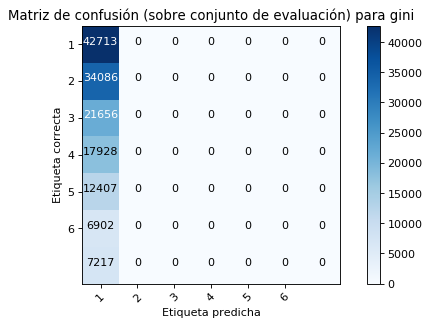

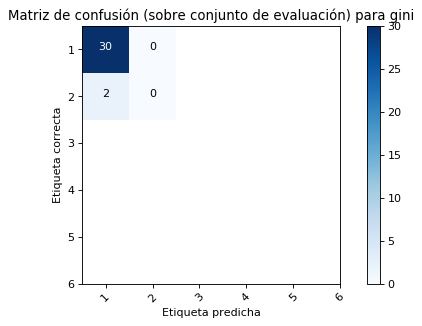

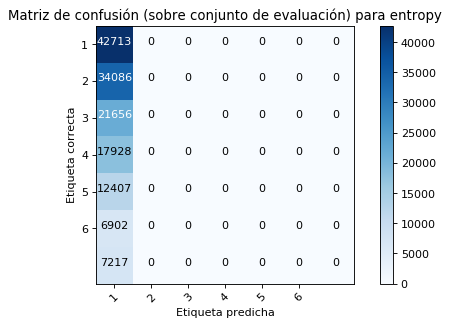

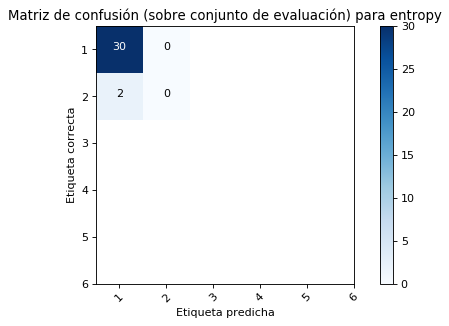

In [187]:
for idx, criterion in enumerate(('gini','entropy'),start=1):
    exploring_params = {
        "max_depth" :  [20, 21, 22],
        "min_samples_leaf" : [2,3,4]
    }
    m = tree.DecisionTreeClassifier(criterion=criterion)
    model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy') #cv se le especifica el 5-fold cross validation
    model.fit(X_train, y_train["shipment_days_byclass"])
    print("# Exploración de hiperparámetros para función criterion \"%s\"" % criterion, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")
    
    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    print()
    
    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test["shipment_days_byclass"], model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("================================================", end="\n\n")
    
    plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, idx)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=target_names, title="Matriz de confusión (sobre conjunto de evaluación) para %s" % criterion)
    

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de entrenamiento):", end="\n\n")
    y_true_t, y_pred_t = y_train["shipment_days_byclass"], model.predict(X_train)
    print(classification_report(y_true_t, y_pred_t), end="\n\n")
    
    print("================================================", end="\n\n")
    
    plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, idx)
    plot_confusion_matrix(confusion_matrix(y_true_t, y_pred_t),
                          classes=target_names, title="Matriz de confusión (sobre conjunto de evaluación) para %s" % criterion)
    
    print ("Accuracy on test is ", accuracy_score(y_test["shipment_days_byclass"], y_pred)*100)
    print ("Accuracy on training is ", accuracy_score(y_train["shipment_days_byclass"], y_pred_t)*100)
    
    print("================================================", end="\n\n")    
  

### SGDClassifier

In [0]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

m = SGDClassifier()

m.fit(X_train, y_train["shipment_days_byclass"])

print("Reporte de clasificación para el clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test["shipment_days_byclass"], m.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")

print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))

print('Accuracy of SGDC classifier on training set: {:.2f}' .format(m.score(X_train, y_train["shipment_days_byclass"])))
print('Accuracy of SGDC classifier on test set: {:.2f}'.format(m.score(X_test, y_test["shipment_days_byclass"])))

Reporte de clasificación para el clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           5       1.00      0.50      0.67     31996
          10       0.00      0.00      0.00        11
          15       0.00      0.00      0.00         0

    accuracy                           0.50     32007
   macro avg       0.33      0.17      0.22     32007
weighted avg       1.00      0.50      0.67     32007



Matriz de confusión:
[[15974     0 16022]
 [    1     0    10]
 [    0     0     0]]
Accuracy of SGDC classifier on training set: 0.33
Accuracy of SGDC classifier on test set: 0.50


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<Figure size 1120x320 with 0 Axes>

SGDC clasificador tampoco nos esta dando los resultados esperados, lo podesmo observar en la matriz de confusión.

###Clasificacion Multiclase

In [0]:
penalty = 'l1' 
alpha =  .001#10#1#.5 
model = LogisticRegression(penalty=penalty, C=1./alpha, multi_class='ovr')
model.fit(X_train, y_train['shipment_days'])

print('Exactitud para entrenamiento: %.2f' %  accuracy_score(y_train['shipment_days'], model.predict(X_train)))
print('Exactitud para validación: %.2f' % accuracy_score(y_test['shipment_days'], model.predict(X_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Exactitud para entrenamiento: 0.22
Exactitud para validación: 0.51


In [0]:
plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')
print(confusion_matrix(y_train['shipment_days'], model.predict(X_train)))
plt.show()

[[  879 10659   216 ...     0     0     0]
 [ 1122 57849  4875 ...     0     0     0]
 [   20 39743  7405 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     1     0 ...     0     0     0]
 [    0     0     1 ...     0     0     0]]


<Figure size 1920x1600 with 0 Axes>

In [0]:
plt.figure(figsize=(24, 20), dpi= 80, facecolor='w', edgecolor='k')

print(confusion_matrix(y_test['shipment_days'], model.predict(X_test)))

plt.show()

[[  208  1486     0    47    12     0     0]
 [  207 14172   874   893    60     0     0]
 [    5  6216  1177  1370    88     0     0]
 [    0  2506   524   684    12     0     0]
 [    1   740   193   240     0     0     0]
 [    0   160    53    68     0     0     0]
 [    0     5     2     4     0     0     0]]


<Figure size 1920x1600 with 0 Axes>

Por mas que el accuracy nos esta dando bien, al ver la matriz de confusión podemos ver que estamos obteniendo un resultado que no es el esperado. Estaríamos esperando una columna con ceros fuera de la diagonal o al menos cercanos a cero para la mayor parte de las clases. Por ende desiciontree no se comporta como esperabamos para nuestro dataset.

###Regresion Polinomial

In [0]:
np.random.seed(1234)

En esta sección probaremos entrenar un modelo usando el feature shipment_days en su verisón numérica.

**Usando solo receiver_zipcode como feature**  

Con el objetivo de mostrar una visualización, en primer lugar seleccionamos un solo feature (receiver_zipcode) para entrenar el modelo con una regresión polinomial.

In [0]:
X_train_pol = np.array(X_train['receiver_zipcode']).reshape(-1,1)

In [0]:
X_test_pol = np.array (X_test['receiver_zipcode']).reshape(-1,1)

In [0]:
y_train_pol = np.array(y_train['shipment_days']).reshape(-1,1)

In [0]:
y_test_pol = np.array(y_test['shipment_days']).reshape(-1,1)

Verificamos los tamaños de los conjuntos.

In [0]:
X_train_pol.shape

(345316, 1)

In [0]:
y_train_pol.shape

(345316, 1)

In [0]:
X_test_pol.shape

(32007, 1)

In [0]:
y_test_pol.shape

(32007, 1)

In [0]:
polynomial_degree = 5 

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train_pol, model.predict(X_poly_train)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_test_pol, model.predict(X_poly_test)))

Media del error cuadrado para entrenamiento: 15.26
Media del error cuadrado para validación: 6.59


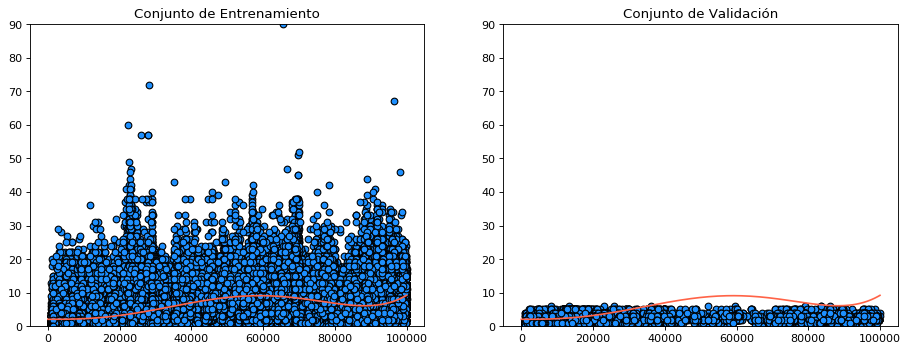

In [0]:
plt.figure(figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')

X_range_start = np.min(np.r_[X_train, X_test])
X_range_stop = np.max(np.r_[X_train, X_test])

y_range_start = np.min(np.r_[y_train, y_test])
y_range_stop = np.max(np.r_[y_train, y_test])

X_linspace = np.linspace(X_range_start, X_range_stop, 200).reshape(-1, 1)
X_linspace_poly = poly_features.transform(X_linspace)

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(X_train_pol, y_train_pol, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Entrenamiento")

# Conjunto de validación
plt.subplot(1, 2, 2)
plt.scatter(X_test_pol, y_test_pol, facecolor="dodgerblue", edgecolor="k", label="datos")
plt.plot(X_linspace, model.predict(X_linspace_poly), color="tomato", label="modelo")
plt.ylim(y_range_start, y_range_stop)
plt.title("Conjunto de Validación")

plt.show()

De acuerdo a los resultados anteriores los errores sobre el conjunto de entrenamiento y validación son bastante altos. Esto también se evidencia en las visualizaciones donde la regresión polinomial no proporciona un buen ajuste de los datos.

Es importante notar que el modelo anterior fue entrenado teniendo en cuenta un solo feature, veamos que sucede si al modelo le agregamos la variable service.



**Regresión polinomial teniendo en cuenta la variables service y receiver_zipcode**

In [0]:
X_train_pol = X_train
X_test_pol = X_test
y_train_pol = y_train['shipment_days']
y_test_pol = y_test['shipment_days']

In [0]:
polynomial_degree = 5 

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train_pol, model.predict(X_poly_train)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_test_pol, model.predict(X_poly_test)))

Media del error cuadrado para entrenamiento: 12.38
Media del error cuadrado para validación: 4.83


La adición de la variable service tuvo un impacto postivo pues ambos errores se redujeron aunque sigen siendo altos. Esto podría confirmar nuestra hipótesis de que estos dos features en combinación son relevantes al momento de predecir cuando llega un envío. 

**Regresión polinomial teniendo en cuenta la variables service, receiver_zipcode y receiver_state con label encoder**

In [0]:
X_train = df_train[['receiver_zipcode','service','receiver_state_le']]

In [0]:
y_train = df_train[['shipment_days']]

In [0]:
X_test = df_test[['receiver_zipcode','service','receiver_state_le']]

In [0]:
y_test = df_test[['shipment_days']]

In [0]:
X_train_pol = X_train

In [0]:
X_test_pol = X_test

In [0]:
y_train_pol = y_train

In [0]:
y_test_pol = y_test

In [0]:
polynomial_degree = 5 

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train_pol, model.predict(X_poly_train)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_test_pol, model.predict(X_poly_test)))

Media del error cuadrado para entrenamiento: 12.03
Media del error cuadrado para validación: 4.78


Observamos que la adición del feature receiver_zipcode con label encoder provocó una muy leve disminución en los errores con respecto al último valor obtenido. Veremos ahora como responde el modelo si tenemos en cuenta el OneHotEnconding de la misma variable.

**Regresión polinomial teniendo en cuenta la variables service, receiver_zipcode y receiver_state con OneHotEnconding**

In [0]:
X_train = df_train[['receiver_zipcode','service','receiver_state_AC',
       'receiver_state_AL', 'receiver_state_AM', 'receiver_state_AP',
       'receiver_state_BA', 'receiver_state_CE', 'receiver_state_DF',
       'receiver_state_ES', 'receiver_state_GO', 'receiver_state_MA',
       'receiver_state_MG', 'receiver_state_MS', 'receiver_state_MT',
       'receiver_state_PA', 'receiver_state_PB', 'receiver_state_PE',
       'receiver_state_PI', 'receiver_state_PR', 'receiver_state_RJ',
       'receiver_state_RN', 'receiver_state_RO', 'receiver_state_RR',
       'receiver_state_RS', 'receiver_state_SC', 'receiver_state_SE',
       'receiver_state_SP', 'receiver_state_TO']]

In [0]:
y_train = df_train[['shipment_days']]

In [0]:
X_test = df_test[['receiver_zipcode','service','receiver_state_AC',
       'receiver_state_AL', 'receiver_state_AM', 'receiver_state_AP',
       'receiver_state_BA', 'receiver_state_CE', 'receiver_state_DF',
       'receiver_state_ES', 'receiver_state_GO', 'receiver_state_MA',
       'receiver_state_MG', 'receiver_state_MS', 'receiver_state_MT',
       'receiver_state_PA', 'receiver_state_PB', 'receiver_state_PE',
       'receiver_state_PI', 'receiver_state_PR', 'receiver_state_RJ',
       'receiver_state_RN', 'receiver_state_RO', 'receiver_state_RR',
       'receiver_state_RS', 'receiver_state_SC', 'receiver_state_SE',
       'receiver_state_SP', 'receiver_state_TO']]

In [0]:
y_test = df_test[['shipment_days']]

In [0]:
X_train_pol = X_train

In [0]:
X_test_pol = X_test

In [0]:
y_train_pol = y_train

In [0]:
y_test_pol = y_test

In [0]:
polynomial_degree = 2 

poly_features = PolynomialFeatures(polynomial_degree)
poly_features.fit(X_train_pol)

X_poly_train = poly_features.transform(X_train_pol)
X_poly_test = poly_features.transform(X_test_pol)

model = LinearRegression()
model.fit(X_poly_train, y_train_pol)

print('Media del error cuadrado para entrenamiento: %.2f' % 
      mean_squared_error(y_train_pol, model.predict(X_poly_train)))
print('Media del error cuadrado para validación: %.2f' %
      mean_squared_error(y_test_pol, model.predict(X_poly_test)))

Media del error cuadrado para entrenamiento: 12.75
Media del error cuadrado para validación: 5.32


Si bien todos los errores de aplicar regresión polinomial son del mismo orden, los mejores han sido obtenidos aplicando una regresión polinomial de grado 5 usando los features receiver_zipcode, service y receiver_state con labelencoder.

###Conclusiones y trabajo futuro

Luego de haber realizado pruebas con diferentes modelos de aprendizaje automático, los resultados demuestran que el dataset con el cual estamos trabajando es bastante particular para responder como uno esperaría. 

Creemos que otros modelos (como redes neuronales u otra clase de modelos no supervisados) podrían responder mejor y deberían ser probados en un futuro cercano como así también una normalización de los datos. También se podría definir o usar otras métricas más representativas para el problema. No obstante, consideramos que el trabajo realizado hasta ahora tiene un valor importante y forma parte del proceso de trabajar con datos reales.

